In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from data_generators.basic_generator import BasicDataGenerator
from environments.pricing_environment import PricingEnvironment
from learners.pricing.thompson_sampling import ThompsonSampling
from learners.pricing.ucb import UCB
from learners.pricing.contextual_learner import ContextualLearner
from environments.contextual_environment import ContextualEnvironment
from utils.context_generator_v2 import ContextGenerator

In [2]:
dg = BasicDataGenerator(filename='src/basic001.json')
sel_bid = 3
fixed_clicks = np.rint(dg.get_daily_clicks(mode='aggregate')[sel_bid]).astype(int)
fixed_cost = dg.get_costs_per_click(mode='aggregate')[sel_bid]
env_params = {
    'features': dg.get_features(),
    'customer_classes': dg.get_classes(),
    'conversion_rates': dg.get_conversion_rates(mode='all'),
    'future_purchases': dg.get_future_purchases(mode='all'),
    'daily_clicks': fixed_clicks,
    'cost_per_click': fixed_cost
}
margins = dg.get_margins()
fractions = []
for cl in dg.get_classes().values():
    fractions.append(cl['fraction'])

args = {
    'arm_values': dg.get_margins()
}

In [3]:
print('\n', 15 * '-', 'SIMULATION PARAMS', '-' * 15)
T = 365
n_experiments = 10
print(f'Time horizon: {T} days')
print(f'Num. experiments: {n_experiments}')


 --------------- SIMULATION PARAMS ---------------
Time horizon: 365 days
Num. experiments: 10


In [4]:
opt_arms = []
global_opt = 0

for i, conv_rate in enumerate(dg.get_conversion_rates(mode='all')):
    opt_arm = np.argmax(margins[i] * conv_rate * (1 + dg.get_future_purchases()[i]) - fixed_cost)
    opt_value = np.max(margins[i] * conv_rate * (1 + dg.get_future_purchases()[i]) - fixed_cost)
    opt_arms.append((opt_arm, opt_value))
    global_opt += fractions[i]*opt_value

print(f'N_ARMS: {len(margins)}')
print(f'Optimal arm: {str(opt_arms)}')
print(f'Fractions: {fractions}')
print(f'Global opt: {global_opt}')

N_ARMS: 10
Optimal arm: [(1, 19.912999999999997), (0, 8.063), (0, 15.543000000000001)]
Fractions: [0.2, 0.35, 0.45]
Global opt: 13.799


In [5]:
learners_to_test = [ThompsonSampling, UCB]
rewards_per_experiment = {}
context_split_experiment = {}
for learner in learners_to_test:
    rewards_per_experiment[learner.LEARNER_NAME] = []
    context_split_experiment[learner.LEARNER_NAME] = []

print(f'N_ROUNDS: {T}')
print(f'N_EXPERIMENTS: {n_experiments}')
print(f'ALGORITHMS: {list(rewards_per_experiment.keys())}')
start_from = 60
frequency = 15
confidence = 0.001

N_ROUNDS: 365
N_EXPERIMENTS: 10
ALGORITHMS: ['TS-Pricing', 'UCB-Pricing']


In [6]:
for e in range(n_experiments):
    # Initialization of the learners to test and their related environment:
    # the list is composed of tuples (Learner, Environment)
    print(f'{"//"*12} exp#{e} {"//"*12}')
    test_instances = []
    for learner in learners_to_test:
        context_learner = ContextualLearner(dg.get_features(), learner, **args)
        test_instances.append(
            (context_learner,
            ContextualEnvironment(**env_params),
            ContextGenerator(dg.get_features(), context_learner, update_frequency=frequency, start_from=start_from, confidence=confidence))
        )
        
    for t in range(T):
        for context_learner, env, context_generator  in test_instances:
            context_learner.next_day()
            past_arms = None
            past_features = None
            month_purchases = env.get_next_purchases_at_day(t, keep=False)
            if month_purchases is not None:
                past_arms = env.get_selected_arms_at_day(t - 30, keep=False)
                past_features= env.get_collected_user_features_at_day(t - 30, keep=False)
                context_learner.update_next_purchases(past_arms,
                                                      month_purchases, 
                                                      past_features)

            pulled_arms = context_learner.pull_arms()
            daily_rewards = env.day_round(pulled_arms)
            daily_users_features = env.get_collected_user_features_at_day(t)
            daily_pulled_arms = env.get_selected_arms_at_day(t)

            context_learner.update(daily_rewards, daily_pulled_arms, daily_users_features)
            context_generator.collect_daily_data(daily_pulled_arms, daily_rewards, daily_users_features, 
                                                 next_purchases=month_purchases, past_pulled_arms=past_arms, past_features=past_features)
        
    for learner, _, _ in test_instances:
        learner.next_day()
        rewards_per_experiment[learner.base_learner_class.LEARNER_NAME].append(learner.get_daily_rewards())
        context_split_experiment[learner.base_learner_class.LEARNER_NAME].append(learner.get_splits_count())

//////////////////////// exp#0 ////////////////////////

-------------------- RUNNING CONTEXT GENERATOR@t=60 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-1', 'feature-2']
Analysis of the feature `feature-1`...
Analysis of the feature `feature-2`...
	Values after the split: [9.395913757525983, 9.39760688870162]
	Value before the split: 13.695415114277047


-------------------- RUNNING CONTEXT GENERATOR@t=60 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-1', 'feature-2']
Analysis of the feature `feature-1`...
Analysis of the feature `feature-2`...
	Values after the split: [9.825751019269564, 9.883702089851704]
	Value before the split: 12.38059777386837


-------------------- RUNNING CONTEXT GENERATOR@t=75 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-1', 'feature-2']

Analysis of the feature `feature-2`...
	Values after the split: [13.113783665933946, 13.137579630486398]
	Value before the split: 12.57431937852385

	best_feature='feature-2'
NEW CONTEXT GENERATED:
 splitting into -> {'feature-2': False} and {'feature-2': True}

-------------------- RUNNING CONTEXT GENERATOR@t=75 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-1', 'feature-2']
Analysis of the feature `feature-1`...
Analysis of the feature `feature-2`...
	Values after the split: [9.474985245270814, 10.116457843679862]
	Value before the split: 12.362686777431458


-------------------- RUNNING CONTEXT GENERATOR@t=90 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']
Analysis of the feature `feature-1`...
	Values after the split: [11.535780731858829]
	Value before the split: 11.322950649034697

	best_feature='feature-1'
NEW CON

	Values after the split: [10.545173489480494, 9.921511250135662]
	Value before the split: 12.031750415046664


-------------------- RUNNING CONTEXT GENERATOR@t=360 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-1', 'feature-2']
Analysis of the feature `feature-1`...
Analysis of the feature `feature-2`...
	Values after the split: [10.5500647993205, 9.924042383107437]
	Value before the split: 12.55906660984075

//////////////////////// exp#2 ////////////////////////

-------------------- RUNNING CONTEXT GENERATOR@t=60 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-1', 'feature-2']
Analysis of the feature `feature-1`...
Analysis of the feature `feature-2`...
	Values after the split: [10.527151057361447, 10.49900407178989]
	Value before the split: 12.804635488639933


-------------------- RUNNING CONTEXT GENERATOR@t=60 --------------------
N_LE


-------------------- RUNNING CONTEXT GENERATOR@t=270 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-1', 'feature-2']
Analysis of the feature `feature-1`...
Analysis of the feature `feature-2`...
	Values after the split: [6.452817300562755, 6.141100322578934]
	Value before the split: 12.62795877501231


-------------------- RUNNING CONTEXT GENERATOR@t=285 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-1', 'feature-2']
Analysis of the feature `feature-1`...
Analysis of the feature `feature-2`...
	Values after the split: [6.455351153974231, 6.143846119472657]
	Value before the split: 12.699016381297076


-------------------- RUNNING CONTEXT GENERATOR@t=300 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-1', 'feature-2']
Analysis of the feature `feature-1`...
Analysis of 

Analysis of the feature `feature-2`...
	Values after the split: [9.810202847877434, 9.922670044388417]
	Value before the split: 12.689393808691529


-------------------- RUNNING CONTEXT GENERATOR@t=165 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']
Analysis of the feature `feature-1`...
	Values after the split: [11.21711879395767]
	Value before the split: 11.927698510803603


-------------------- RUNNING CONTEXT GENERATOR@t=165 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-1', 'feature-2']
Analysis of the feature `feature-1`...
Analysis of the feature `feature-2`...
	Values after the split: [9.87960109557071, 9.947446522809258]
	Value before the split: 12.734088217996346


-------------------- RUNNING CONTEXT GENERATOR@t=180 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-2': False} 

Analysis of the feature `feature-2`...
	Values after the split: [12.995581614735638, 14.432913456627173]
	Value before the split: 12.371767289026378

	best_feature='feature-2'
NEW CONTEXT GENERATED:
 splitting into -> {'feature-2': False} and {'feature-2': True}

-------------------- RUNNING CONTEXT GENERATOR@t=75 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-1', 'feature-2']
Analysis of the feature `feature-1`...
Analysis of the feature `feature-2`...
	Values after the split: [7.995371802435331, 7.976587798437929]
	Value before the split: 11.110492907366874


-------------------- RUNNING CONTEXT GENERATOR@t=90 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']
Analysis of the feature `feature-1`...
	Values after the split: [10.973622063940653]
	Value before the split: 11.297066197067997

- Evaluating the Node: feature_su


-------------------- RUNNING CONTEXT GENERATOR@t=300 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-1', 'feature-2']
Analysis of the feature `feature-1`...
Analysis of the feature `feature-2`...
	Values after the split: [9.919442669082152, 10.02951905286611]
	Value before the split: 12.70948664810146


-------------------- RUNNING CONTEXT GENERATOR@t=315 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-1', 'feature-2']
Analysis of the feature `feature-1`...
Analysis of the feature `feature-2`...
	Values after the split: [9.924066140542969, 10.031488797612877]
	Value before the split: 11.3372005150875


-------------------- RUNNING CONTEXT GENERATOR@t=330 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-1', 'feature-2']
Analysis of the feature `feature-1`...
Analysis of t

Analysis of the feature `feature-2`...
	Values after the split: [9.358703262517452, 8.943572676388037]
	Value before the split: 12.15837687343133


-------------------- RUNNING CONTEXT GENERATOR@t=225 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-1', 'feature-2']
Analysis of the feature `feature-1`...
Analysis of the feature `feature-2`...
	Values after the split: [9.364089615962367, 8.950063541746012]
	Value before the split: 12.858397749424729


-------------------- RUNNING CONTEXT GENERATOR@t=240 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-1', 'feature-2']
Analysis of the feature `feature-1`...
Analysis of the feature `feature-2`...
	Values after the split: [9.368284430414125, 8.955969473254502]
	Value before the split: 12.82020318726874


-------------------- RUNNING CONTEXT GENERATOR@t=255 --------------------
N_LEAVES: 1
- Evaluat

Analysis of the feature `feature-2`...
	Values after the split: [12.076864652182094, 8.952865818731517]
	Value before the split: 12.819101111116387


-------------------- RUNNING CONTEXT GENERATOR@t=165 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-1', 'feature-2']
Analysis of the feature `feature-1`...
Analysis of the feature `feature-2`...
	Values after the split: [12.09998258561982, 8.955223617210724]
	Value before the split: 11.927900082061802

	best_feature='feature-1'
NEW CONTEXT GENERATED:
 splitting into -> {'feature-1': False} and {'feature-1': True}

-------------------- RUNNING CONTEXT GENERATOR@t=180 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-1': False} - is_leaf=True

Features to check: ['feature-2']
Analysis of the feature `feature-2`...
	Values after the split: [8.784564867597348]
	Value before the split: 9.990559777112228

- Evaluating the Node: feature_sub

Analysis of the feature `feature-2`...
	Values after the split: [8.116966578408196, 9.259771910007574]
	Value before the split: 12.66895824003257


-------------------- RUNNING CONTEXT GENERATOR@t=165 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']
Analysis of the feature `feature-1`...
	Values after the split: [10.534324569948879]
	Value before the split: 10.79213252402429


-------------------- RUNNING CONTEXT GENERATOR@t=165 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-1', 'feature-2']
Analysis of the feature `feature-1`...
Analysis of the feature `feature-2`...
	Values after the split: [8.12183449367285, 9.272240843221661]
	Value before the split: 12.711270476753386


-------------------- RUNNING CONTEXT GENERATOR@t=180 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={'feature-2': False} -

Analysis of the feature `feature-2`...
	Values after the split: [11.5168276779768, 12.080432478556023]
	Value before the split: 12.888055261925416


-------------------- RUNNING CONTEXT GENERATOR@t=90 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-1', 'feature-2']
Analysis of the feature `feature-1`...
Analysis of the feature `feature-2`...
	Values after the split: [12.661911410850134, 12.8148423051104]
	Value before the split: 12.689960637704385

	best_feature='feature-2'
NEW CONTEXT GENERATED:
 splitting into -> {'feature-2': False} and {'feature-2': True}

-------------------- RUNNING CONTEXT GENERATOR@t=90 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-1', 'feature-2']
Analysis of the feature `feature-1`...
Analysis of the feature `feature-2`...
	Values after the split: [10.944825102921646, 12.736895353393905]
	Value before the split: 1

Analysis of the feature `feature-2`...
	Values after the split: [9.769450706801088, 9.578026551562973]
	Value before the split: 12.885104783853947


-------------------- RUNNING CONTEXT GENERATOR@t=120 --------------------
N_LEAVES: 2
- Evaluating the Node: feature_subspace={'feature-2': False} - is_leaf=True

Features to check: ['feature-1']
Analysis of the feature `feature-1`...
	Values after the split: [11.316920340731556]
	Value before the split: 11.841296483455247

- Evaluating the Node: feature_subspace={'feature-2': True} - is_leaf=True

Features to check: ['feature-1']
Analysis of the feature `feature-1`...
	Values after the split: [15.731770741863738]
	Value before the split: 15.19726006418177

	best_feature='feature-1'
NEW CONTEXT GENERATED:
 splitting into -> {'feature-2': True, 'feature-1': False} and {'feature-2': True, 'feature-1': True}

-------------------- RUNNING CONTEXT GENERATOR@t=120 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_l

Analysis of the feature `feature-2`...
	Values after the split: [9.862231859167569, 9.675853784460639]
	Value before the split: 12.670426083231963


-------------------- RUNNING CONTEXT GENERATOR@t=300 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-1', 'feature-2']
Analysis of the feature `feature-1`...
Analysis of the feature `feature-2`...
	Values after the split: [9.868045337742823, 9.680323329262858]
	Value before the split: 12.652530613158753


-------------------- RUNNING CONTEXT GENERATOR@t=315 --------------------
N_LEAVES: 1
- Evaluating the Node: feature_subspace={} - is_leaf=True

Features to check: ['feature-1', 'feature-2']
Analysis of the feature `feature-1`...
Analysis of the feature `feature-2`...
	Values after the split: [9.8735308300349, 9.687038152745078]
	Value before the split: 12.602658995647163


-------------------- RUNNING CONTEXT GENERATOR@t=330 --------------------
N_LEAVES: 1
- Evaluat

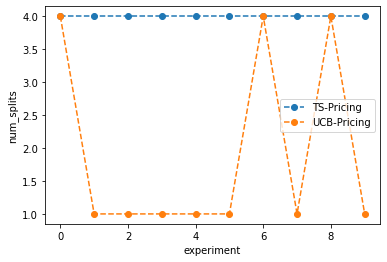

In [7]:
plt.figure()
plt.ylabel("num_splits")
plt.xlabel("experiment")
for val in context_split_experiment.values():
    plt.plot(val, '--o')
plt.legend(context_split_experiment.keys())
plt.show()

In [8]:
for key in context_split_experiment:
    print(f'{key}: avg splits -> {np.mean(context_split_experiment[key])}')

TS-Pricing: avg splits -> 4.0
UCB-Pricing: avg splits -> 1.9


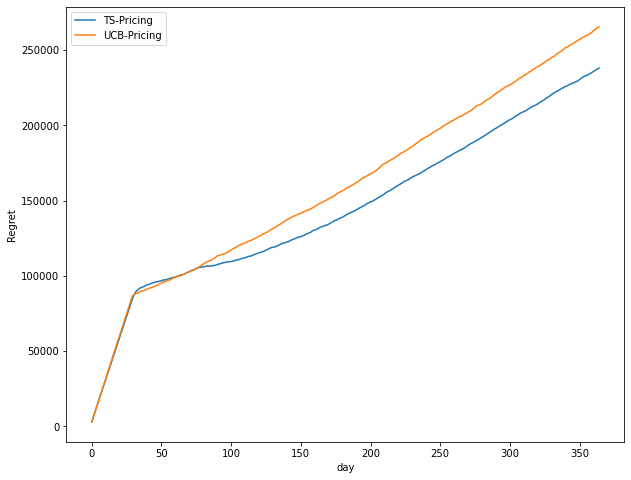

In [9]:
# Plotting the results
plt.figure(figsize=(10,8))
plt.ylabel("Regret")
plt.xlabel("day")
opt = global_opt * fixed_clicks
for val in rewards_per_experiment.values():
    plt.plot(np.cumsum(np.mean(opt - val, axis=0)))
plt.legend(rewards_per_experiment.keys())
plt.show()

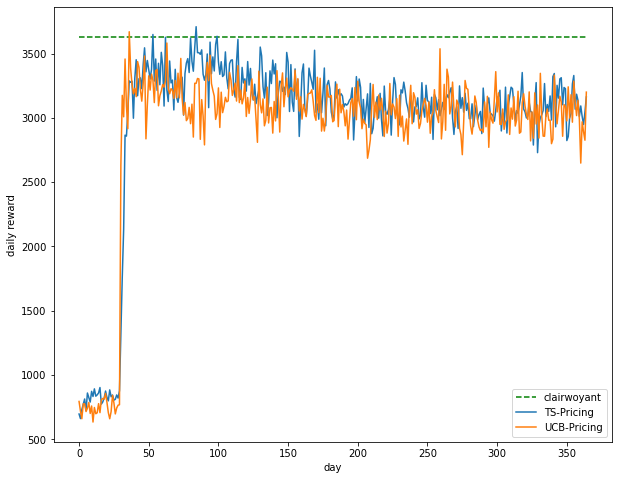

In [10]:
plt.figure(figsize=(10,8))
plt.xlabel("day")
plt.ylabel("daily reward")
plt.plot([opt]*365, '--g', label='clairwoyant')
for key in rewards_per_experiment:
    plt.plot(np.mean(rewards_per_experiment[key], axis=0), label=key)
plt.legend(loc='best')
plt.show()